In [2]:
import matplotlib.pyplot as pp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import analyse_methods as am
from importlib import reload
import os
%matplotlib widget

In [3]:
elements = [
    "h", "he", "li", "be", "b", "c", "n", "o", "f", "ne",
    "na", "mg", "al", "si", "p", "s", "cl", "ar", "k", "ca",
    "sc", "ti", "v", "cr", "mn", "fe", "co", "ni", "cu", "zn",
    "ga", "ge", "as", "se", "br", "kr", "rb", "sr", "y", "zr",
    "nb", "mo", "tc", "ru", "rh", "pd", "ag", "cd", "in", "sn",
    "sb", "te", "i", "xe", "cs", "ba", "la", "ce", "pr", "nd",
    "pm", "sm", "eu", "gd", "tb", "dy", "ho", "er", "tm", "yb",
    "lu", "hf", "ta", "w", "re", "os", "ir", "pt", "au", "hg",
    "tl", "pb", "bi", "po", "at", "rn", "fr", "ra", "ac", "th",
    "pa", "u", "np", "pu", "am", "cm", "bk", "cf", "es", "fm",
    "md", "no", "lr", "rf", "db", "sg", "bh", "hs", "mt", "ds",
    "rg", "cn", "nh", "fl", "mc", "lv", "ts", "og"
]

In [4]:
blocks_dict = {
    "s-block": ["li", "be", "na", "mg", "k", "ca",],
    "d-block": ["sc", "ti", "v", "cr", "mn", "fe", "co", "ni", "cu", "zn",
          ],
    "p-block": ["he", "b", "c", "n", "o", "f", "ne",
          "al", "si", "p", "s", "cl", "ar",
          "ga", "ge", "as", "se", "br", "kr"]
}



In [9]:
# ~~ CHATGPT SUGGESTS
reload(am)
def plot_single(ax, basis=None, atom=None, charge=None, fname=None, names=None, **plotkwargs):
    """Plot energy vs gamma for a one file."""
    if fname != None:
        data = pd.read_csv(fname, names=names, skipinitialspace=True)
    else:
        data = am.get_evsgamma(atom, basis, charge=charge)
    if data is None:
        return None
    line, = ax.plot(
        data.GEM_BETA, data.E - min(data.E),
        **plotkwargs,
    )
    return line, data


def plot_all_elements(basis, elements, blocks_dict, save=False):
    nblocks = len(blocks_dict)

    # Grid layout for subplots
    ncols = int(nblocks**0.5 + 0.5)
    nrows = (nblocks + ncols - 1) // ncols

    fig, axes = pp.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), squeeze=False)
    axes = axes.flatten()

    fig._axis_data = []  # store per-axis metadata in the figure

    axnum = 0
    cmap = pp.get_cmap("viridis")
    
    for ax, (block, data_list) in zip(axes, blocks_dict.items()):
        ax.set_title(f"{block}")
        n = len(data_list)

        norm = mcolors.Normalize(vmin=0, vmax=n-1)

        line_map = {}  # for this axis
        active_element = {"name": None}

        for i, atom in enumerate(data_list):
            #print(atom)
            color = cmap(norm(i))
            
            if atom.startswith('FILE:'):
                fname, label = atom.split('>LABEL:')
                fname = fname.lstrip('FILE:')
                line, data = plot_single(
                    ax, fname=fname, 
                    color=color, lw=1.5, label=label
                )
            
            else:
                if '+' in atom:
                    atom, charge = atom.split('+')
                    charge = f'+{charge}'
                elif '-' in atom:
                    atom, charge = atom.split('-')
                    charge = f'-{charge}'
                else:
                    charge = 0
                label = f"{atom}{charge if charge else ''}".title()
                charge = int(charge)
                
                
                
                line, data = plot_single(
                    ax, basis=basis, atom=atom, charge=charge, 
                    color=color, lw=1.5, label=label
                )
                
            print(label)
            line_map[label] = line
            gamma_min = am.get_min(data)
            #ax.axvline(gamma_min, color=line.get_color(), linestyle="--")
        if axnum // ncols == nrows -1:
            ax.set_xlabel(r"$\gamma$")
        if axnum % ncols == 0:
            ax.set_ylabel("Energy (H)")
        axnum+=1
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = pp.colorbar(sm, ax=ax, ticks=range(n))
        #cbar.set_label("Element")
        cbar.set_ticklabels(line_map.keys())

        # Make tick labels pickable
        for label in cbar.ax.get_yticklabels():
            label.set_picker(True)

        ax.set_ylim(0, 0.02)
        ax.set_xlim(0.75, 2.75)

        # store metadata: axis, lines, active element, and cbar ticklabels
        fig._axis_data.append({
            "ax": ax,
            "line_map": line_map,
            "active_element": active_element,
            "ticklabels": cbar.ax.get_yticklabels(),
        })

    # remove unused subplots if any
    for ax in axes[nblocks:]:
        fig.delaxes(ax)

    # --- Interactive toggle logic ---
    def on_pick(event):
        if isinstance(event.artist, pp.Text):
            picked_label = event.artist.get_text()
    
            for axis_info in fig._axis_data:
                if event.artist in axis_info["ticklabels"]:
                    line_map = axis_info["line_map"]
                    active_element = axis_info["active_element"]
    
                    if picked_label not in line_map:
                        continue
    
                    if active_element["name"] == picked_label:
                        # Reset all lines
                        for line in line_map.values():
                            line.set_alpha(1.0)
                        # Reset label style
                        event.artist.set_fontweight("normal")
                        active_element["name"] = None
                    else:
                        # Highlight picked, dim others
                        for atom, line in line_map.items():
                            line.set_alpha(1.0 if atom == picked_label else 0.25)
                        # Reset all label styles in this axis
                        for lbl in axis_info["ticklabels"]:
                            lbl.set_fontweight("normal")
                        # Set active label bold
                        event.artist.set_fontweight("bold")
                        active_element["name"] = picked_label
    
                    fig.canvas.draw_idle()
                    break  # stop after finding the right axis

    fig.canvas.mpl_connect("pick_event", on_pick)

    if save:
        fname = f"energy_vs_gamma_{basis}.svg"
        fig.savefig(fname)

    fig.suptitle(rf"Energy vs $\gamma$ for {basis}")
    return fig


Cu+1
Cu
N
NH3


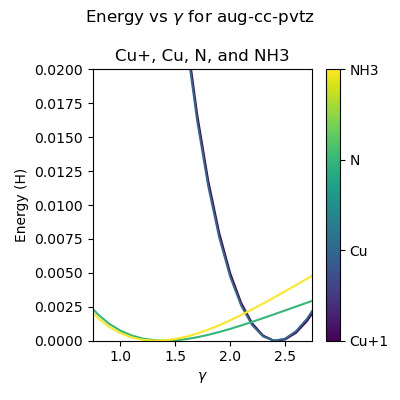

In [11]:
bases = ["aug-cc-pvtz", "awcvtz"]
#basis= bases[0]
basis = bases[0]
fig = plot_all_elements(
    basis, elements, {
        "Cu+, Cu, N, and NH3":
        ["cu+1", "cu", "n", 'FILE:../dimers/cu_nh3/optimize_nh3_gamma/table_nh3_0_aug-cc-pvtz.csv>LABEL:NH3'],
                      
                    #"d": ["sc", "ti", "v", "cr", "mn", "fe", "co", "ni", "cu", "zn",],
                     })#blocks_dict)

fig.suptitle(fr'Energy vs $\gamma$ for {basis}')
fig.tight_layout()

In [12]:
fig.savefig('comparing_cu_cu1_n_nh3.svg')

In [8]:
plot_single(fig.gca(), fname='../dimers/cu_nh3/optimize_nh3_gamma/table_nh3_0_aug-cc-pvtz.csv')

(<matplotlib.lines.Line2D at 0x150999a1d590>,
     GEM_BETA         E
 0        0.5 -0.257192
 1        0.6 -0.258644
 2        0.7 -0.259756
 3        0.8 -0.260601
 4        0.9 -0.261231
 5        1.0 -0.261683
 6        1.1 -0.261988
 7        1.2 -0.262167
 8        1.3 -0.262237
 9        1.4 -0.262215
 10       1.5 -0.262111
 11       1.6 -0.261938
 12       1.7 -0.261706
 13       1.8 -0.261423
 14       1.9 -0.261097
 15       2.0 -0.260736
 16       2.1 -0.260346
 17       2.2 -0.259932
 18       2.3 -0.259500
 19       2.4 -0.259055
 20       2.5 -0.258599
 21       2.6 -0.258137
 22       2.7 -0.257671
 23       2.8 -0.257203
 24       2.9 -0.256737)

In [57]:
"df".title()

'Df'

In [ ]:
blocks_dict['noble'] = ['he', 'ne', 'ar']
fig = plot_all_elements(
    basis, elements, blocks_dict)
fig.tight_layout()

In [ ]:
fig.savefig("energy_vs_gamma_elements_by_block.svg")